Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokeniz

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokeniz

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, token

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /DATA/deep_learning/dependencies/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Processing image: /DATA/deep_learning/04-20_03-30_vae_train_imgs/epoch_99/train_image_473.png
Using prompt: A high-quality photograph
Enhancing with depth...
Loading model from: /DATA/deep_learning/dependencies/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Processing image: /DATA/deep_learning/04-20_03-30_vae_train_imgs/epoch_99/train_image_473.png
Using prompt: A high-quality photograph
Enhancing with depth...


  0%|          | 0/16 [00:00<?, ?it/s]

Enhancing with blurred depth...


  0%|          | 0/16 [00:00<?, ?it/s]

Enhancing without depth (standard img2img)...


  0%|          | 0/16 [00:00<?, ?it/s]


--- Results ---

-- With Depth --
PSNR   : 17.1731
SSIM   : 0.6108
MS-SSIM: 0.7029
LPIPS  : 0.4100

-- With Blurred Depth --
PSNR   : 15.9468
SSIM   : 0.5677
MS-SSIM: 0.6198
LPIPS  : 0.4310

-- Without Depth --
PSNR   : 15.1263
SSIM   : 0.5378
MS-SSIM: 0.5135
LPIPS  : 0.5169

Displaying images...


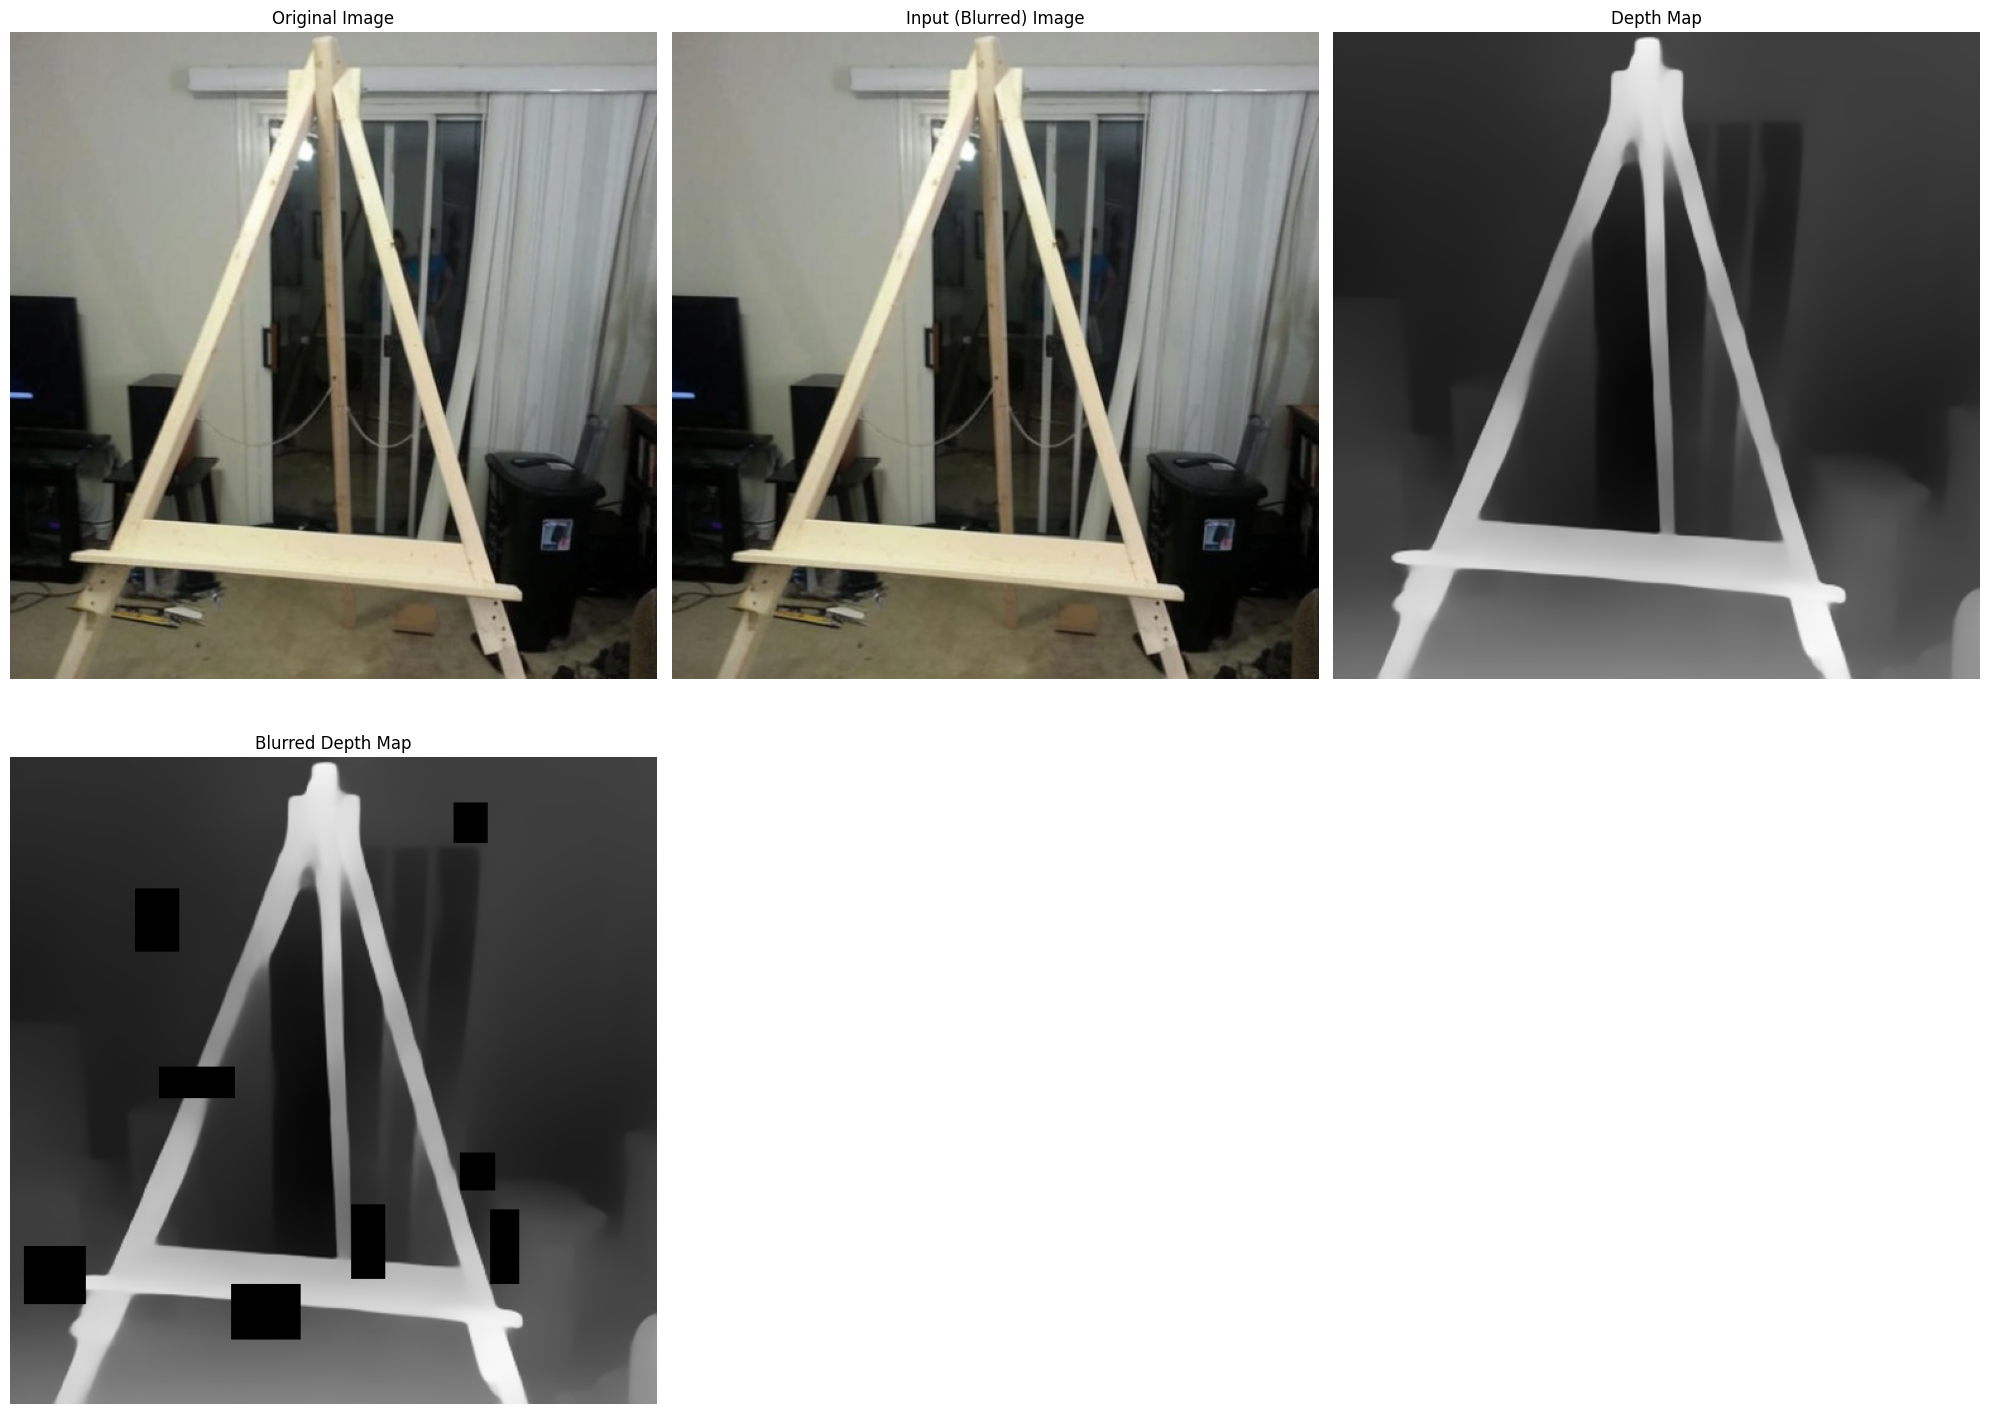

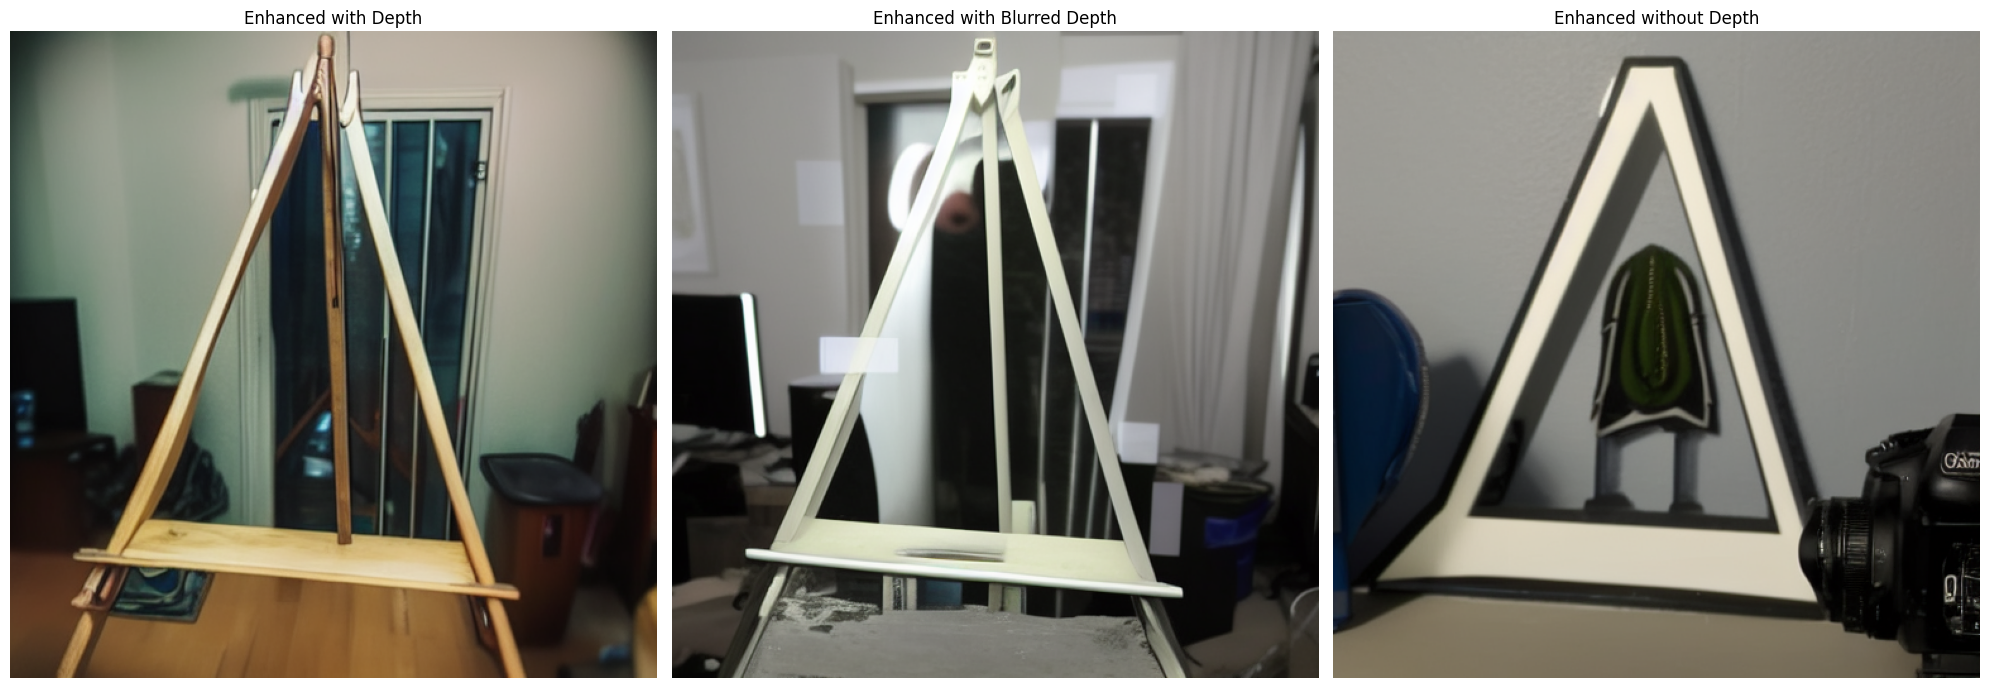


Processing finished.


In [ ]:
import os
import torch
from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetImg2ImgPipeline,
    StableDiffusionImg2ImgPipeline,
    UniPCMultistepScheduler
)
from PIL import Image, ImageFilter
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from pytorch_msssim import ms_ssim
import lpips
import torchvision.transforms.functional as TF
# Import IPython display functions for Jupyter
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# -----------------------------
# 1. Setup pipelines/models
# -----------------------------
# ControlNet-guided Img2Img
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth",
    torch_dtype=torch.float16
)
pipe_with_depth = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_with_depth.scheduler = UniPCMultistepScheduler.from_config(pipe_with_depth.scheduler.config)
pipe_with_depth.enable_xformers_memory_efficient_attention()
pipe_with_depth.enable_model_cpu_offload()
pipe_with_depth.to("cuda")

pipe_with_blurreddepth = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_with_blurreddepth.scheduler = UniPCMultistepScheduler.from_config(pipe_with_depth.scheduler.config)
pipe_with_blurreddepth.enable_xformers_memory_efficient_attention()
pipe_with_blurreddepth.enable_model_cpu_offload()
pipe_with_blurreddepth.to("cuda")

# Standard Img2Img (no depth)
pipe_without_depth = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    torch_dtype=torch.float16
)
pipe_without_depth.scheduler = UniPCMultistepScheduler.from_config(pipe_without_depth.scheduler.config)
pipe_without_depth.enable_xformers_memory_efficient_attention()
pipe_without_depth.enable_model_cpu_offload()
pipe_without_depth.to("cuda")

# LPIPS model
lpips_fn = lpips.LPIPS(net="alex").to("cuda")

# -----------------------------
# 2. Metrics calculation
# -----------------------------

def calculate_metrics(orig: Image.Image, enhanced: Image.Image):
    orig_np = np.array(orig).astype(np.float32)
    enh_np  = np.array(enhanced).astype(np.float32)
    _psnr   = psnr(orig_np, enh_np, data_range=255)
    _ssim   = ssim(orig_np, enh_np, data_range=255, channel_axis=-1, win_size=7)
    orig_t  = TF.to_tensor(orig).unsqueeze(0).to("cuda")
    enh_t   = TF.to_tensor(enhanced).unsqueeze(0).to("cuda")
    _mssim  = ms_ssim(orig_t, enh_t, data_range=1.0, size_average=True).item()
    orig_lp = orig_t * 2 - 1
    enh_lp  = enh_t  * 2 - 1
    _lpips  = lpips_fn(orig_lp, enh_lp).item()
    return {
        "PSNR":    _psnr,
        "SSIM":    _ssim,
        "MS-SSIM": _mssim,
        "LPIPS":   _lpips
    }

# Helper function to display multiple images in a grid
def display_images(images_dict, figsize=(20, 15), columns=3):
    """Display multiple images in a grid layout with titles"""
    n = len(images_dict)
    rows = (n + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, (title, img) in enumerate(images_dict.items()):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3. Single Image Processing
# -----------------------------

# Define input file paths and prompt
# --- USER: Please replace these paths with your actual file paths ---
original_image_path = "output/images/04-20_03-30_vae_train_imgs/epoch_99/train_image_473.png"
blurred_image_path = original_image_path
depth_map_path = "output/images/output_depth_map.png"
blurred_depth_map_path = "output/images/blurred_output_depth_map_gaussian.png"
prompt = "A high-quality photograph" # --- USER: Define your prompt ---
output_save_dir = "output/images/single_output" # Optional: Directory to save results
os.makedirs(output_save_dir, exist_ok=True)

# --- Input Validation ---
if not os.path.exists(original_image_path):
    raise FileNotFoundError(f"Original image not found: {original_image_path}")
if not os.path.exists(blurred_image_path):
    raise FileNotFoundError(f"Blurred/Input image not found: {blurred_image_path}")
if not os.path.exists(depth_map_path):
    raise FileNotFoundError(f"Depth map not found: {depth_map_path}")
if not os.path.exists(blurred_depth_map_path):
    raise FileNotFoundError(f"Blurred depth map not found: {blurred_depth_map_path}")

# Load images
orig_img = Image.open(original_image_path).convert("RGB").resize((512, 512))
blur_img = Image.open(blurred_image_path).convert("RGB").resize((512, 512))
depth_img = Image.open(depth_map_path).convert("RGB").resize((512, 512))
blurred_depth_img = Image.open(blurred_depth_map_path).convert("RGB").resize((512, 512))

print(f"Processing image: {original_image_path}")
print(f"Using prompt: {prompt}")

# Enhance with depth
print("Enhancing with depth...")
out_with_depth = pipe_with_depth(
    prompt=prompt,
    image=blur_img,
    control_image=depth_img,
    num_inference_steps=20
).images[0]
out_with_depth.save(os.path.join(output_save_dir, "enhanced_with_depth.png"))
metrics_with_depth = calculate_metrics(orig_img, out_with_depth)

# Enhance with blurred depth
print("Enhancing with blurred depth...")
out_with_blurred_depth = pipe_with_blurreddepth(
    prompt=prompt,
    image=blur_img,
    control_image=blurred_depth_img,
    num_inference_steps=20
).images[0]
out_with_blurred_depth.save(os.path.join(output_save_dir, "enhanced_with_blurred_depth.png"))
metrics_with_blurred_depth = calculate_metrics(orig_img, out_with_blurred_depth)

# Enhance without depth
print("Enhancing without depth (standard img2img)...")
out_without_depth = pipe_without_depth(
    prompt=prompt,
    image=blur_img,
    num_inference_steps=20
).images[0]
out_without_depth.save(os.path.join(output_save_dir, "enhanced_without_depth.png"))
metrics_without_depth = calculate_metrics(orig_img, out_without_depth)

# -----------------------------
# 4. Display Results and Metrics
# -----------------------------

print("\n--- Results ---")

print("\n-- With Depth --")
for k, v in metrics_with_depth.items(): print(f"{k:7s}: {v:.4f}")
print("\n-- With Blurred Depth --")
for k, v in metrics_with_blurred_depth.items(): print(f"{k:7s}: {v:.4f}")
print("\n-- Without Depth --")
for k, v in metrics_without_depth.items(): print(f"{k:7s}: {v:.4f}")

# Display images in Jupyter notebook instead of external viewer
print("\nDisplaying images...")

# First, display input images
input_images = {
    "Original Image": orig_img,
    "Input (Blurred) Image": blur_img,
    "Depth Map": depth_img,
    "Blurred Depth Map": blurred_depth_img
}
display_images(input_images)

# Then, display output images
output_images = {
    "Enhanced with Depth": out_with_depth,
    "Enhanced with Blurred Depth": out_with_blurred_depth,
    "Enhanced without Depth": out_without_depth
}
display_images(output_images)

print("\nProcessing finished.")
